In [1]:
from datasets import Dataset
from gpn.data import GenomeMSA
from gpn.msa.inference import run_inference
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from scipy.spatial.distance import cdist
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cols = ["chrom", "pos", "ref", "alt"]

def match_columns(df, target, covariates):
    pos = df[df[target]]
    neg = df[~df[target]]
    D = cdist(pos[covariates], neg[covariates])
    #print(np.min(D, axis=1).max())
    
    # approach 1: has the issue of ties
    #closest = np.argmin(D, axis=1)
    
    # approach 2: greedy, depends on order of snps
    closest = []
    dists = []
    for i in range(len(pos)):
        j = np.argmin(D[i])
        closest.append(j)
        #dists.append(D[i,j])
        D[:, j] = np.inf  # ensure it cannot be picked up again
    #print(max(dists))
    return pd.concat([pos, neg.iloc[closest]])

In [3]:
genome_msa = GenomeMSA("../../results/msa/multiz100way/89/all.zarr")

Loading MSA...
Loading MSA... Done


In [173]:
from gpn.data import Tokenizer, ReverseComplementer
import gpn.model
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoModelForMaskedLM


class VEPEmbedding(torch.nn.Module):
    def __init__(self, model_path, embedding_mean=None, embedding_std=None):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_path)
        if embedding_mean is not None and embedding_std is not None:
            self.register_buffer("embedding_mean", torch.tensor(embedding_mean))
            self.register_buffer("embedding_std", torch.tensor(embedding_std))
        else:
            self.embedding_mean = None

    def get_embedding(self, input_ids, aux_features, exclude_pos=None):
        embedding = self.model(
            input_ids=input_ids, aux_features=aux_features,
        ).last_hidden_state
        
        if exclude_pos is not None:
            embedding = torch.cat((embedding[:, :exclude_pos], embedding[:, exclude_pos+1:]), dim=1)

        # chosing specific layer
        #hidden_states = self.model(
        #    input_ids=input_ids, aux_features=aux_features,
        #    output_hidden_states=True,
        #).hidden_states # note 0 is the encoder, so last layer is 12, not 11
        #embedding = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)  
            
        if self.embedding_mean is not None:
            embedding = (embedding - self.embedding_mean) / self.embedding_std
        
        # this usually on
        embedding = embedding.reshape(len(input_ids), -1)
        
        return embedding
    
    def get_scores(self, input_ids_ref, aux_features_ref, input_ids_alt, aux_features_alt, exclude_pos=None):
        embedding_ref = self.get_embedding(input_ids_ref, aux_features_ref, exclude_pos=exclude_pos)
        embedding_alt = self.get_embedding(input_ids_alt, aux_features_alt, exclude_pos=exclude_pos)
        #return torch.stack((embedding_ref, embedding_alt), dim=1)
        return (
            F.pairwise_distance(embedding_ref, embedding_alt),
            (embedding_ref * embedding_alt).sum(dim=1),  # dot product
            F.cosine_similarity(embedding_ref, embedding_alt),
        )

    def forward(
        self,
        input_ids_ref_fwd=None,
        aux_features_ref_fwd=None,
        input_ids_alt_fwd=None,
        aux_features_alt_fwd=None,
        input_ids_ref_rev=None,
        aux_features_ref_rev=None,
        input_ids_alt_rev=None,
        aux_features_alt_rev=None,
    ):
        W = input_ids_ref_fwd.shape[1]

        #return torch.cat((
        #    self.get_scores(input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd),
        #    self.get_scores(input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev),
        #), dim=1)
        #return res
        fwd1, fwd2, fwd3 = self.get_scores(
            input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd,
            #exclude_pos=W//2,
        )
        rev1, rev2, rev3 = self.get_scores(
            input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev,
            #exclude_pos=(W//2) - 1,
        )
        #return torch.stack((fwd1, fwd2, fwd3), dim=1)
        #return torch.stack((rev1, rev2, rev3), dim=1)
        return torch.stack((
            (fwd1 + rev1) / 2,
            (fwd2 + rev2) / 2,
            (fwd3 + rev3) / 2,
        
        ), dim=1)


class VEPEmbeddingInference(object):
    def __init__(self, model_path, genome_msa, window_size):
        self.model = VEPEmbedding(model_path)#, embedding_mean=embedding_mean, embedding_std=embedding_std)
        self.genome_msa = genome_msa
        self.window_size = window_size
        self.tokenizer = Tokenizer()
        self.reverse_complementer = ReverseComplementer()

    def tokenize_function(self, V):
        # we convert from 1-based coordinate (standard in VCF) to
        # 0-based, to use with GenomeMSA
        chrom = np.array(V["chrom"])
        pos = np.array(V["pos"]) - 1
        start = pos - self.window_size // 2
        end = pos + self.window_size // 2
        
        msa_fwd, msa_rev = self.genome_msa.get_msa_batch_fwd_rev(
            chrom,
            start,
            end,
            tokenize=True,
        )
        pos_fwd = self.window_size // 2
        pos_rev = pos_fwd - 1 if self.window_size % 2 == 0 else pos_fwd

        ref_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["ref"]]
        )
        alt_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["alt"]]
        )
        ref_rev = self.reverse_complementer(ref_fwd)
        alt_rev = self.reverse_complementer(alt_fwd)

        def prepare_output(msa, pos, ref, alt):
            ref, alt = self.tokenizer(ref.flatten()), self.tokenizer(alt.flatten())
            input_ids, aux_features = msa[:, :, 0], msa[:, :, 1:]
            assert (
                input_ids[:, pos] == ref
            ).all(), f"{input_ids[:, pos].tolist()}, {ref.tolist()}"
            input_ids_alt = input_ids.copy()
            input_ids_alt[:, pos] = alt
            input_ids = input_ids.astype(np.int64)
            input_ids_alt = input_ids_alt.astype(np.int64)
            return input_ids, aux_features, input_ids_alt, aux_features

        res = {}
        (
            res["input_ids_ref_fwd"],
            res["aux_features_ref_fwd"],
            res["input_ids_alt_fwd"],
            res["aux_features_alt_fwd"],
        ) = prepare_output(msa_fwd, pos_fwd, ref_fwd, alt_fwd)
        (
            res["input_ids_ref_rev"],
            res["aux_features_ref_rev"],
            res["input_ids_alt_rev"],
            res["aux_features_alt_rev"],
        ) = prepare_output(msa_rev, pos_rev, ref_rev, alt_rev)
        return res

    def postprocess(self, pred):
        return pred
        #return pd.DataFrame(pred, columns=["euclidean_distance", "inner_product", "cosine_similarity"])
        #return pd.DataFrame(pred, columns=["score"])


def score_vep(V2):
    dataset = Dataset.from_pandas(V2[cols])
    inference = VEPEmbeddingInference("songlab/gpn-msa-sapiens", genome_msa, 128)
    pred = run_inference(
        dataset,
        inference,
        per_device_batch_size=256,
        dataloader_num_workers=8,
    )
    return pred


def add_scores(V2):
    V2.loc[:, ["euclidean_distance", "inner_product", "cosine_similarity"]] = score_vep(V2).values
    V2.euclidean_distance *= -1
    V2.cosine_similarity -= V2.cosine_similarity.max()
    V2.inner_product -= V2.inner_product.max()
    return V2

In [160]:
def jsd_logits(logits_p, logits_q):
    logprob_p = F.log_softmax(logits_p, dim=2)
    logprob_q = F.log_softmax(logits_q, dim=2)
    return 0.5 * (
        F.kl_div(logprob_p, logprob_q, log_target=True, reduction="none").sum(dim=(1,2)) +
        F.kl_div(logprob_q, logprob_p, log_target=True, reduction="none").sum(dim=(1,2))
    )

class VEPLogits(torch.nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.model = AutoModelForMaskedLM.from_pretrained(model_path)

    def get_logits(self, input_ids, aux_features, exclude_pos=None):
        logits = self.model(
            input_ids=input_ids, aux_features=aux_features,
        ).logits
        
        if exclude_pos is not None:
            logits = torch.cat((logits[:, :exclude_pos], logits[:, exclude_pos+1:]), dim=1)
        
        return logits
    
    def get_score(self, input_ids_ref, aux_features_ref, input_ids_alt, aux_features_alt, exclude_pos=None):
        logits_ref = self.get_logits(input_ids_ref, aux_features_ref, exclude_pos=exclude_pos)
        logits_alt = self.get_logits(input_ids_alt, aux_features_alt, exclude_pos=exclude_pos)
        return jsd_logits(logits_ref, logits_alt)
        
    def forward(
        self,
        input_ids_ref_fwd=None,
        aux_features_ref_fwd=None,
        input_ids_alt_fwd=None,
        aux_features_alt_fwd=None,
        input_ids_ref_rev=None,
        aux_features_ref_rev=None,
        input_ids_alt_rev=None,
        aux_features_alt_rev=None,
    ):
        W = input_ids_ref_fwd.shape[1]
        fwd = self.get_score(
            input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd,
            exclude_pos=W//2
        )
        rev = self.get_score(
            input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev,
            exclude_pos=(W//2)-1
        )
        return (fwd + rev) / 2
   

class VEPLogitsInference(object):
    def __init__(self, model_path, genome_msa, window_size):
        self.model = VEPLogits(model_path)
        self.genome_msa = genome_msa
        self.window_size = window_size
        self.tokenizer = Tokenizer()
        self.reverse_complementer = ReverseComplementer()

    def tokenize_function(self, V):
        # we convert from 1-based coordinate (standard in VCF) to
        # 0-based, to use with GenomeMSA
        chrom = np.array(V["chrom"])
        pos = np.array(V["pos"]) - 1
        start = pos - self.window_size // 2
        end = pos + self.window_size // 2
        
        msa_fwd, msa_rev = self.genome_msa.get_msa_batch_fwd_rev(
            chrom,
            start,
            end,
            tokenize=True,
        )
        pos_fwd = self.window_size // 2
        pos_rev = pos_fwd - 1 if self.window_size % 2 == 0 else pos_fwd

        ref_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["ref"]]
        )
        alt_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["alt"]]
        )
        ref_rev = self.reverse_complementer(ref_fwd)
        alt_rev = self.reverse_complementer(alt_fwd)

        def prepare_output(msa, pos, ref, alt):
            ref, alt = self.tokenizer(ref.flatten()), self.tokenizer(alt.flatten())
            input_ids, aux_features = msa[:, :, 0], msa[:, :, 1:]
            assert (
                input_ids[:, pos] == ref
            ).all(), f"{input_ids[:, pos].tolist()}, {ref.tolist()}"
            input_ids_alt = input_ids.copy()
            input_ids_alt[:, pos] = alt
            input_ids = input_ids.astype(np.int64)
            input_ids_alt = input_ids_alt.astype(np.int64)
            return input_ids, aux_features, input_ids_alt, aux_features

        res = {}
        (
            res["input_ids_ref_fwd"],
            res["aux_features_ref_fwd"],
            res["input_ids_alt_fwd"],
            res["aux_features_alt_fwd"],
        ) = prepare_output(msa_fwd, pos_fwd, ref_fwd, alt_fwd)
        (
            res["input_ids_ref_rev"],
            res["aux_features_ref_rev"],
            res["input_ids_alt_rev"],
            res["aux_features_alt_rev"],
        ) = prepare_output(msa_rev, pos_rev, ref_rev, alt_rev)
        return res

    def postprocess(self, pred):
        return pred
        #return pd.DataFrame(pred, columns=["euclidean_distance", "inner_product", "cosine_similarity"])
        #return pd.DataFrame(pred, columns=["score"])


def score_vep_logits(V2):
    dataset = Dataset.from_pandas(V2[cols])
    inference = VEPLogitsInference("songlab/gpn-msa-sapiens", genome_msa, 128)
    pred = run_inference(
        dataset,
        inference,
        per_device_batch_size=256,
        dataloader_num_workers=8,
    )
    return pred

In [6]:
ldscore = pd.read_parquet("../../results/tmp/ldscore.processed.parquet")
ldscore

,chrom,pos,ref,alt,AF,ld_score
0,1,11063,T,G,0.000048,5.738593
1,1,13259,G,A,0.000278,5.048821
2,1,17641,G,A,0.000831,1.683291
3,1,57222,T,C,0.000659,2.475932
4,1,58396,T,C,0.00024,29.534102
...,...,...,...,...,...,...
22153592,X,155697134,G,A,0.000028,28.358136
22153593,X,155697920,G,A,0.302726,406.085388
22153594,X,155699751,C,T,0.245915,483.126375
22153595,X,155700569,A,G,0.246325,484.684299


In [7]:
ldscore["MAF"] = ldscore['AF'].apply(lambda x: min(x, 1-x))

In [8]:
pips = pd.read_parquet("../../results/tmp/my_pips.parquet")
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [9]:
pips = pips[pips.method=="SUSIE"]
pips = pips[(~pips.LD_HWE) & (~pips.LD_SV)]
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [10]:
# option 1
pips_agg = pips.groupby(cols).agg({"pip": "sum", "maf": "mean", "trait": "count"}).reset_index().rename(columns={"trait": "n_traits"})
pips_agg["pip"] = pips_agg.pip / len(pips.trait.unique())  # average pip

# option 2
#pips_agg = pips.groupby(cols).agg({"pip": "max", "maf": "mean"}).reset_index()
#pips_agg

In [11]:
models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/upweight_phyloP_and_phastCons_flip_0.1_0.5_msa",
    "CADD.RawScore",
    "phyloP",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/upweight_phyloP_and_phastCons_flip_0.1_0.5_msa": "GPN-MSA",
}

V = pd.read_parquet("../../results/finemapping/processed/test.parquet")
d = Path(f"../../results/preds/results/finemapping/processed")
for m in models:
    model_name = model_renaming.get(m, m)
    if m in V.columns:
        V.rename(columns={m: model_name}, inplace=True)
        continue
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP
0,1,832873,A,C,0.487101,0.145778,0.677
1,1,833068,G,A,1.751498,0.016390,-0.036
2,1,834583,G,A,0.339468,0.051453,0.479
3,1,835506,G,A,-0.253357,0.177210,0.645
4,1,841852,C,T,0.046023,0.025537,0.459
...,...,...,...,...,...,...,...
1821943,22,50783624,G,A,-0.883718,-0.438139,0.932
1821944,22,50784537,G,A,0.073284,-0.645151,-0.249
1821945,22,50790482,G,A,0.051396,0.020462,-0.349
1821946,22,50791289,A,T,-0.813960,-0.261473,-0.062


In [12]:
V = V.merge(ldscore, on=cols, how="inner")
V

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF
0,1,832873,A,C,0.487101,0.145778,0.677,0.763689,65.233773,0.236311
1,1,833068,G,A,1.751498,0.016390,-0.036,0.105508,39.035791,0.105508
2,1,834583,G,A,0.339468,0.051453,0.479,0.104803,39.16434,0.104803
3,1,835506,G,A,-0.253357,0.177210,0.645,0.103867,38.977357,0.103867
4,1,841852,C,T,0.046023,0.025537,0.459,0.095105,39.579469,0.095105
...,...,...,...,...,...,...,...,...,...,...
1816798,22,50783624,G,A,-0.883718,-0.438139,0.932,0.299913,38.986375,0.299913
1816799,22,50784537,G,A,0.073284,-0.645151,-0.249,0.30374,39.121952,0.303740
1816800,22,50790482,G,A,0.051396,0.020462,-0.349,0.299102,37.73791,0.299102
1816801,22,50791289,A,T,-0.813960,-0.261473,-0.062,0.295325,37.576431,0.295325


In [13]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [14]:
not_na = ~V[models].isna().any(axis=1)
not_na.mean()

0.9887593756725412

In [15]:
V = V[not_na]
V.shape

(1796381, 10)

## Aggregate

In [199]:
from scipy.stats import zscore

V2 = V.merge(pips_agg, how="inner", on=cols).sort_values("pip", ascending=False)
V2["maf_z"] = zscore(V2["maf"])
V2["ld_score_z"] = zscore(V2["ld_score"].astype(float))

# option 1
V2.loc[V2.pip.rank(ascending=False) <= 1000, "Likely causal"] = True   # 1000
V2.loc[V2.pip.rank() <= 100_000, "Likely causal"] = False

# option 2
#V2.loc[V2.pip > 1-1e-10, "Likely causal"] = True
#V2.loc[V2.pip < 0.002, "Likely causal"] = False

V2 = V2.dropna(subset="Likely causal")
V2["Likely causal"] = V2["Likely causal"].astype(bool)
V2["Likely causal"].value_counts()

Likely causal
False    100000
True       1000
Name: count, dtype: int64

In [200]:
V2 = match_columns(
    V2, "Likely causal",
    [
        "maf_z",
        "ld_score_z"
    ]
)
V2 = V2.drop_duplicates()
V2["Likely causal"].value_counts()

Likely causal
True     1000
False    1000
Name: count, dtype: int64

In [201]:
V2.loc[:, ["euclidean_distance", "inner_product", "cosine_similarity"]] = score_vep(V2)
V2

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,pip,maf,n_traits,maf_z,ld_score_z,Likely causal,euclidean_distance,inner_product,cosine_similarity
162015,2,27508073,T,C,-3.085732,-1.147003,-0.075,0.60702,222.283921,0.392980,0.294152,0.393022,37,1.208642,0.415063,True,42.714710,98765.539062,0.990848
450872,4,102267552,C,T,-3.977336,-2.383603,-1.821,0.074578,107.499194,0.074578,0.214927,0.074813,29,-0.827666,-0.335390,True,49.100784,98073.265625,0.987708
1078197,12,4275678,T,G,-3.413795,-1.036324,0.509,0.02079,9.373644,0.020790,0.189471,0.021026,21,-1.171865,-0.976926,True,27.341904,99161.539062,0.996244
1548058,20,44413724,C,T,-9.917723,-2.277288,-7.873,0.031379,14.199153,0.031379,0.183270,0.031456,21,-1.105117,-0.945377,True,18.441339,99208.328125,0.998288
448132,4,99318162,T,C,-2.632227,-1.131267,-1.178,0.977225,37.569382,0.022775,0.169436,0.022288,19,-1.163789,-0.792585,True,38.332298,98871.890625,0.992623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365924,17,878167,C,T,-1.014494,-0.373673,-0.114,0.097309,26.536287,0.097309,0.000011,0.097188,1,-0.684481,-0.864718,False,14.114077,99683.359375,0.999002
260827,2,192143736,T,A,-6.575644,-1.631243,-2.165,0.370792,51.062557,0.370792,0.000012,0.370459,1,1.064258,-0.704367,False,28.890694,99271.171875,0.995801
1467150,18,76394822,G,A,-0.464374,-0.077052,2.305,0.909925,23.796585,0.090075,0.000011,0.089858,1,-0.731389,-0.882630,False,24.972672,99463.226562,0.996874
298029,3,11728157,T,C,-2.849348,-0.593265,-0.536,0.006498,10.477118,0.006498,0.000011,0.006484,1,-1.264922,-0.969711,False,24.190710,99498.976562,0.997062


In [202]:
models = ["GPN-MSA", "CADD", "phyloP"]

In [203]:
models += ["euclidean_distance", "inner_product", "cosine_similarity"]

In [204]:
V2.euclidean_distance *= -1
V2.cosine_similarity -= V2.cosine_similarity.max()
V2.inner_product -= V2.inner_product.max()
V2

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,pip,maf,n_traits,maf_z,ld_score_z,Likely causal,euclidean_distance,inner_product,cosine_similarity
162015,2,27508073,T,C,-3.085732,-1.147003,-0.075,0.60702,222.283921,0.392980,0.294152,0.393022,37,1.208642,0.415063,True,-42.714710,-1002.867188,-0.008818
450872,4,102267552,C,T,-3.977336,-2.383603,-1.821,0.074578,107.499194,0.074578,0.214927,0.074813,29,-0.827666,-0.335390,True,-49.100784,-1695.140625,-0.011958
1078197,12,4275678,T,G,-3.413795,-1.036324,0.509,0.02079,9.373644,0.020790,0.189471,0.021026,21,-1.171865,-0.976926,True,-27.341904,-606.867188,-0.003421
1548058,20,44413724,C,T,-9.917723,-2.277288,-7.873,0.031379,14.199153,0.031379,0.183270,0.031456,21,-1.105117,-0.945377,True,-18.441339,-560.078125,-0.001377
448132,4,99318162,T,C,-2.632227,-1.131267,-1.178,0.977225,37.569382,0.022775,0.169436,0.022288,19,-1.163789,-0.792585,True,-38.332298,-896.515625,-0.007043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365924,17,878167,C,T,-1.014494,-0.373673,-0.114,0.097309,26.536287,0.097309,0.000011,0.097188,1,-0.684481,-0.864718,False,-14.114077,-85.046875,-0.000664
260827,2,192143736,T,A,-6.575644,-1.631243,-2.165,0.370792,51.062557,0.370792,0.000012,0.370459,1,1.064258,-0.704367,False,-28.890694,-497.234375,-0.003864
1467150,18,76394822,G,A,-0.464374,-0.077052,2.305,0.909925,23.796585,0.090075,0.000011,0.089858,1,-0.731389,-0.882630,False,-24.972672,-305.179688,-0.002792
298029,3,11728157,T,C,-2.849348,-0.593265,-0.536,0.006498,10.477118,0.006498,0.000011,0.006484,1,-1.264922,-0.969711,False,-24.190710,-269.429688,-0.002604


In [205]:
#V2["JSD"] = -score_vep_logits(V2)
#models.append("JSD")
#V2

In [206]:
V2[models].corr(method="spearman")

,GPN-MSA,CADD,phyloP,euclidean_distance,inner_product,cosine_similarity
GPN-MSA,1.000000,0.643565,0.626107,0.297746,0.436261,0.299911
CADD,0.643565,1.000000,0.838512,0.315734,0.458834,0.317693
phyloP,0.626107,0.838512,1.000000,0.233207,0.361510,0.235016
euclidean_distance,0.297746,0.315734,0.233207,1.000000,0.931795,0.999979
inner_product,0.436261,0.458834,0.361510,0.931795,1.000000,0.932725
cosine_similarity,0.299911,0.317693,0.235016,0.999979,0.932725,1.000000


In [207]:
def rank_transform(s):
    return -(s.rank(ascending=False))

for m in ["euclidean_distance", "inner_product", "cosine_similarity"]:#, "JSD"]:
    V2[f"rank(LLR)+rank({m})"] = rank_transform(V2["GPN-MSA"]) + rank_transform(V2[m])
    models.append(f"rank(LLR)+rank({m})")
V2

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,...,n_traits,maf_z,ld_score_z,Likely causal,euclidean_distance,inner_product,cosine_similarity,rank(LLR)+rank(euclidean_distance),rank(LLR)+rank(inner_product),rank(LLR)+rank(cosine_similarity)
162015,2,27508073,T,C,-3.085732,-1.147003,-0.075,0.60702,222.283921,0.392980,...,37,1.208642,0.415063,True,-42.714710,-1002.867188,-0.008818,-3501.0,-3481.0,-3500.0
450872,4,102267552,C,T,-3.977336,-2.383603,-1.821,0.074578,107.499194,0.074578,...,29,-0.827666,-0.335390,True,-49.100784,-1695.140625,-0.011958,-3622.0,-3622.0,-3622.0
1078197,12,4275678,T,G,-3.413795,-1.036324,0.509,0.02079,9.373644,0.020790,...,21,-1.171865,-0.976926,True,-27.341904,-606.867188,-0.003421,-2883.0,-3236.0,-2883.0
1548058,20,44413724,C,T,-9.917723,-2.277288,-7.873,0.031379,14.199153,0.031379,...,21,-1.105117,-0.945377,True,-18.441339,-560.078125,-0.001377,-2787.0,-3566.0,-2788.0
448132,4,99318162,T,C,-2.632227,-1.131267,-1.178,0.977225,37.569382,0.022775,...,19,-1.163789,-0.792585,True,-38.332298,-896.515625,-0.007043,-3425.0,-3406.0,-3425.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365924,17,878167,C,T,-1.014494,-0.373673,-0.114,0.097309,26.536287,0.097309,...,1,-0.684481,-0.864718,False,-14.114077,-85.046875,-0.000664,-979.0,-998.5,-977.0
260827,2,192143736,T,A,-6.575644,-1.631243,-2.165,0.370792,51.062557,0.370792,...,1,1.064258,-0.704367,False,-28.890694,-497.234375,-0.003864,-3332.0,-3287.0,-3334.0
1467150,18,76394822,G,A,-0.464374,-0.077052,2.305,0.909925,23.796585,0.090075,...,1,-0.731389,-0.882630,False,-24.972672,-305.179688,-0.002792,-1490.0,-1361.0,-1487.0
298029,3,11728157,T,C,-2.849348,-0.593265,-0.536,0.006498,10.477118,0.006498,...,1,-1.264922,-0.969711,False,-24.190710,-269.429688,-0.002604,-2619.0,-2475.0,-2616.0


In [208]:
n = len(V2)//2

results = []
for m in models:
    results.append([
        m,
        roc_auc_score(V2["Likely causal"], -V2[m]),
        average_precision_score(V2["Likely causal"], -V2[m]),
        np.mean([(V2.iloc[i][m] < V2.iloc[i+n][m]) for i in range(n)]),
    ])
results = pd.DataFrame(results, columns=["Model", "AUROC", "AUPRC", "Pairwise_accuracy"])
results

,Model,AUROC,AUPRC,Pairwise_accuracy
0,GPN-MSA,0.694877,0.753622,0.694
1,CADD,0.708512,0.769914,0.699
2,phyloP,0.659577,0.720052,0.663
3,euclidean_distance,0.610325,0.600557,0.619
4,inner_product,0.675075,0.683878,0.674
5,cosine_similarity,0.611021,0.601725,0.621
6,rank(LLR)+rank(euclidean_distance),0.679309,0.697322,0.684
7,rank(LLR)+rank(inner_product),0.707531,0.746343,0.715
8,rank(LLR)+rank(cosine_similarity),0.679601,0.698086,0.684


<Axes: xlabel='Pairwise_accuracy', ylabel='Model'>

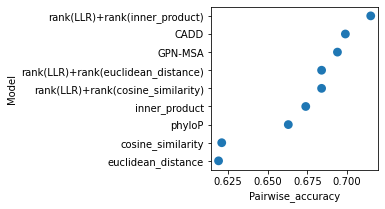

In [209]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("Pairwise_accuracy", ascending=False),
    y="Model",
    x="Pairwise_accuracy",
    join=False,
)

<Axes: xlabel='AUROC', ylabel='Model'>

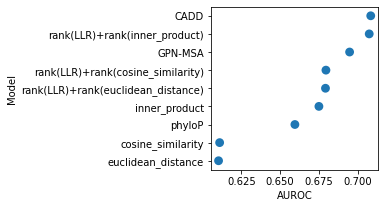

In [210]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("AUROC", ascending=False),
    y="Model",
    x="AUROC",
    join=False,
)

## By trait

In [ ]:
#traits = pips.trait.value_counts().index.values[:10]
#traits = ["Height"]
traits = pips.trait.unique()
traits

In [ ]:
# TODO: should skip datapoints if closest MAF is not small enough

In [ ]:
models = ["GPN-MSA", "CADD", "phyloP"]

In [ ]:
results2 = []
for trait in tqdm(traits):
    V2 = V.merge(pips[pips.trait==trait], how="inner", on=cols).copy()
    V2["maf_z"] = zscore(V2["maf"])
    V2["ld_score_z"] = zscore(V2["ld_score"].astype(float))
    V2.loc[V2.pip < 0.01, "Likely causal"] = False
    V2.loc[V2.pip >  0.9, "Likely causal"] = True
    V2 = V2.dropna(subset="Likely causal")
    V2["Likely causal"] = V2["Likely causal"].astype(bool)
    n = len(V2)
    if (V2["Likely causal"].sum() < 1) or ((~V2["Likely causal"]).sum() < 1): continue
    V2 = match_columns(V2, "Likely causal", ["maf_z", "ld_score_z"])
    V2 = V2.drop_duplicates()
    
    V2 = add_scores(V2)
    models += ["euclidean_distance", "inner_product", "cosine_similarity"]
    for m in ["euclidean_distance", "inner_product", "cosine_similarity"]:
        V2[f"rank(LLR)+rank({m})"] = rank_transform(V2["GPN-MSA"]) + rank_transform(V2[m])
        models.append(f"rank(LLR)+rank({m})")
    
    n_causal = V2["Likely causal"].sum()
    n = n_causal
    for m in models:
        results2.append([
            trait, n_causal, m,
            roc_auc_score(V2["Likely causal"], -V2[m]),
            average_precision_score(V2["Likely causal"], -V2[m]),
            np.mean([(V2.iloc[i][m] < V2.iloc[i+n][m]) for i in range(n)]),
        ])
results2 = pd.DataFrame(results2, columns=["Trait", "n_causal", "Model", "AUROC", "AUPRC", "Pairwise_accuracy"])
results2

In [ ]:
results2.groupby("Model").Pairwise_accuracy.agg(["mean", "median"])

In [ ]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results2,
    y="Model",
    x="Pairwise_accuracy",
    join=False,
    errorbar=None,
)

In [ ]:
plt.plot(results2.groupby("Trait").apply(lambda df: df.query('Model == "GPN-MSA"').iloc[0].Pairwise_accuracy - df.query('Model == "CADD"').iloc[0].Pairwise_accuracy))

In [ ]:
plt.plot(results2.groupby("Trait").apply(lambda df: df.query('Model == "rank(LLR)+rank(inner_product)"').iloc[0].Pairwise_accuracy - df.query('Model == "CADD"').iloc[0].Pairwise_accuracy))